<a href="https://colab.research.google.com/github/lingelizabeth/BWSIfinal/blob/master/Final_Notebook_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**A Machine Learning Algorithm for Detection of Atrial Fibrillation**

Team Members: Phil Mathew, Shashank Jarmale, Lizzy Ling, Annie Liu

**Import Packages**

In [0]:
!pip install peakutils
!pip install imblearn

In [0]:
from scipy.io import * 
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import pandas as pd
import random
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from scipy.interpolate import *
from scipy.signal import *
from sklearn.metrics import roc_curve, auc
from imblearn import over_sampling as imb

In [0]:
!git clone https://github.com/liua13/BWSIFinalProject.git
os.chdir('./BWSIFinalProject') # change directory to repo containing training, validation, and testing data, as well as labels

Cloning into 'BWSIFinalProject'...
remote: Enumerating objects: 8563, done.
remote: Total 8563 (delta 0), reused 0 (delta 0), pack-reused 8563
Receiving objects: 100% (8563/8563), 92.49 MiB | 21.47 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Checking out files: 100% (8533/8533), done.


**Read and filter raw ECG data** 


 

In [0]:
labels = pd.read_csv("labels.csv", names = ['name', 'class'])
labels['class'] = labels['class'].replace('N', 0) # normal (no heart arrythmias)               
labels['class'] = labels['class'].replace('A', 1) # atrial fibrillation
labels['class'] = labels['class'].replace('O', 2) # other heart arrythmia(s)
labels['class'] = labels['class'].replace('~', 3) # noisy signal
labels = labels.drop(["name"], axis=1)
labels.head()

,class
0,0
1,0
2,0
3,1
4,1


In [0]:
df  = pd.read_csv('allrecords.csv', names = ['record name', 'signals', 'frequency', 'sample number', 'date','time','filename', 'format', 
                                             'baseline','adc', 'zeroes', 'initial value','check','block','description', 'NaNs'])
df = df.drop(['signals', 'frequency', 'format', 'baseline', 'filename', 'adc', 'zeroes', 'check', 'block', 'description', 'NaNs'], axis=1) # drop useless or constant features 
df['labels'] = labels['class']
df = df[df['labels'] != 3] # drop the noisy data
df= df.reset_index()
df.head()

,index,record name,sample number,date,time,initial value,labels
0,0,A00001,9000,2014-05-08,05:05:15,-127,0
1,1,A00002,9000,2014-05-16,11:05:25,128,0
2,2,A00003,18000,2014-04-15,12:04:05,56,0
3,3,A00004,9000,2014-05-01,11:05:48,519,1
4,4,A00005,18000,2013-12-23,08:12:08,-188,1


In [0]:
def get_sample_data(i):
    record = df.loc[i,'record name']
    recordnum = int(record[1:6])
    file = "./train" + str(((recordnum - 1)//1000) + 1) + '/' + record + '.mat' #filepath for this file
    a , b = butter(5, .05, 'highpass') # create a butterworth filter
    sample = loadmat(file)["val"][0][0:3000:3] + np.random.normal(0,30,loadmat(file)["val"][0][0:3000:3].shape[0]) # add artificial noise 
    sample = filtfilt(a, b, sample) 
    return sample

In [0]:
def signal_array(start,end):
  features = np.ndarray(shape = ((end-start), 1000)) 
  for i in range(start, end):
    sample = get_sample_data(i)
    
    if(len(sample) < 1000): #pad the data if < 10 seconds long
      features[i - start] = np.pad(sample, pad_width = (0,1000-len(sample)), mode = 'constant', constant_values = 0) 
    else: #use only the first 10 seconds if longer
      features[i - start] = sample[0:1000]
    
    features[i - start] = (features[i - start]-np.mean(features[i - start]))/np.std(features[i - start]) #adds normalized features to array
   
  return features

In [0]:
def reshape_for_NN(arr):
  arr = arr.reshape(arr.shape[0], arr.shape[1], 1) #reshape array to proper input size for neural net
  return arr

In [0]:
tv_data = signal_array(0, 8249) 

ros = imb.SMOTE() #introduce oversampling to reduce impact of noise

X_train, X_val, y_train, y_val = train_test_split(tv_data[0:7248], df['labels'][0:7248], test_size = .25) #split data into training, validation, and test sets

X_train, y_train = ros.fit_sample(X_train, y_train) #apply oversampling function

X_train, X_val = reshape_for_NN(X_train), reshape_for_NN(X_val)

y_train, y_val = tf.keras.utils.to_categorical(y_train), tf.keras.utils.to_categorical(y_val) #convert data into multiclass format for neural net

test_data = reshape_for_NN(tv_data[7248:8249])
test_labels = tf.keras.utils.to_categorical(df['labels'][7248:8249], num_classes = 3)

In [0]:
!git clone https://github.com/PhilMathew/BWSINN.git

Cloning into 'BWSINN'...
remote: Enumerating objects: 15, done.
remote: Total 15 (delta 0), reused 0 (delta 0), pack-reused 15
Unpacking objects: 100% (15/15), done.


**Create CNN model**

In [0]:
os.chdir('./BWSINN')
def create_model(): #set up convolutional neural net (CNN) architecture
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape = (1000,1)))
  model.add(tf.keras.layers.Conv1D(128, kernel_size= 100, activation = tf.nn.relu))
  model.add(tf.keras.layers.AveragePooling1D(pool_size=2 , strides=None, padding='valid', data_format=None))
  model.add(tf.keras.layers.Conv1D(128, kernel_size= 5, activation = tf.nn.relu))
  model.add(tf.keras.layers.AveragePooling1D(pool_size=2 , strides=None, padding='valid', data_format=None))
  model.add(tf.keras.layers.Conv1D(64, kernel_size= 3, activation = tf.nn.relu))
  model.add(tf.keras.layers.GlobalAveragePooling1D())
  model.add(tf.keras.layers.Dropout(.25))
  model.add(tf.keras.layers.Dense(3, activation = tf.nn.softmax)) #returns probability of 3 classes
  return model
  
model = create_model()
model.load_weights('SLAPNet_MkII.h5') #loads weights from SLAPNet
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 901, 128)          12928     
_________________________________________________________________
average_pooling1d (AveragePo (None, 450, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 446, 128)          82048     
_________________________________________________________________
average_pooling1d_1 (Average (None, 223, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 221, 64)           24640     
_________________________________________________________________
global_average_poolin

**Test and evaluate model**

In [0]:
neulog_predict = model.predict(test_data)
print(neulog_predict)

[[9.5382828e-01 1.6886866e-05 4.6154745e-02]
 [7.9530442e-01 5.9642168e-03 1.9873129e-01]
 [9.3175697e-01 1.5125457e-03 6.6730477e-02]
 ...
 [8.6442852e-01 8.4052021e-03 1.2716626e-01]
 [7.4881703e-01 7.8192033e-02 1.7299084e-01]
 [9.4173414e-01 5.9249677e-04 5.7673328e-02]]


Accuracy: 0.6863136863136863
[[0.87260035 0.05235602 0.07504363]
 [0.20952381 0.67619048 0.11428571]
 [0.43343653 0.20743034 0.35913313]]


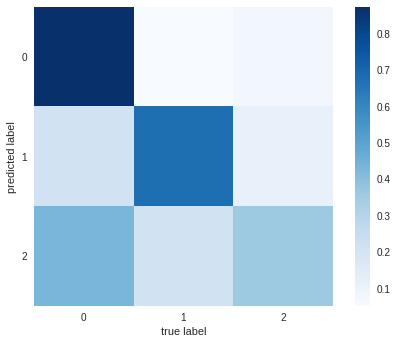

In [0]:
from sklearn import metrics
#print raw accuracy
print('Accuracy:', metrics.accuracy_score(np.argmax(test_labels, axis = 1),np.argmax(neulog_predict, axis=1)))
#generate confusion matrix
cm = metrics.confusion_matrix(np.argmax(test_labels, axis = 1),np.argmax(neulog_predict, axis=1), labels = [0,1,2]) 
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(0,3, step = 1))
plt.yticks(np.arange(0,3,step = 1))
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.grid(False)

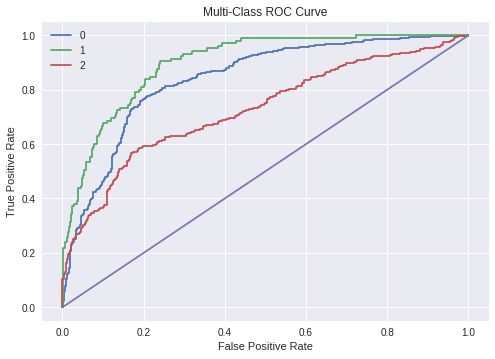

ROC_AUC:  0.8559402635326712


In [0]:
y_pred = model.predict_proba(test_data) #predict probabilities on test data

fpr = {} # false positive rate
tpr = {} # true positive rate
roc_auc = {} # area under the roc curve

for i in range(3):
    #calculate false positive rate and true positive rate
    fpr[i], tpr[i], _ = metrics.roc_curve(test_labels[:, i], y_pred[:, i]) 
    roc_auc[i] = metrics.auc(fpr[i], tpr[i]) 
    plt.plot(fpr[i], tpr[i], label = str(i))
#display area under the curve using above metrics
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend()
plt.show()
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(test_labels.ravel(), y_pred.ravel())
roc_auc = metrics.auc(fpr["micro"], tpr["micro"])
print('ROC_AUC: ', roc_auc)

**Run model on real-time Neulog Data**

In [0]:
up = files.upload()

for i in up:
  filename = i
print(filename)

Saving philecg.csv to philecg.csv
philecg.csv


In [0]:
df2 = pd.read_csv(filename) # read Neulog ECG signal
df2 = df2.drop(df2.index[1007:1009]) 
df2 = df2.drop(df2.index[0:6])

neu = np.array(df2[str(filename[0:-4])]).astype('float')
a , b = butter(5, .05, 'highpass') 
neu = filtfilt(a, b, neu) # apply butterworth filter to data
neu = (neu - np.mean(neu))/np.std(neu) # normalize data
neu = neu[0:1000].reshape(1, 1000, 1) # reshape neulog data array to allow for passing into model

pred = np.argmax(model.predict(neu), axis = 1) # make prediction on Neulog data

if(pred == 1): 
  pred = 'Atrial Fibrillation Detected'
elif(pred == 2): 
  pred = 'No Atrial Fibrillation Detected, but Signs of Other Arrhythmia Detected'
else:
  pred = 'No Signs of Heart Arrythmia Detected'
  
print(pred)

No Signs of Heart Arrythmia Detected


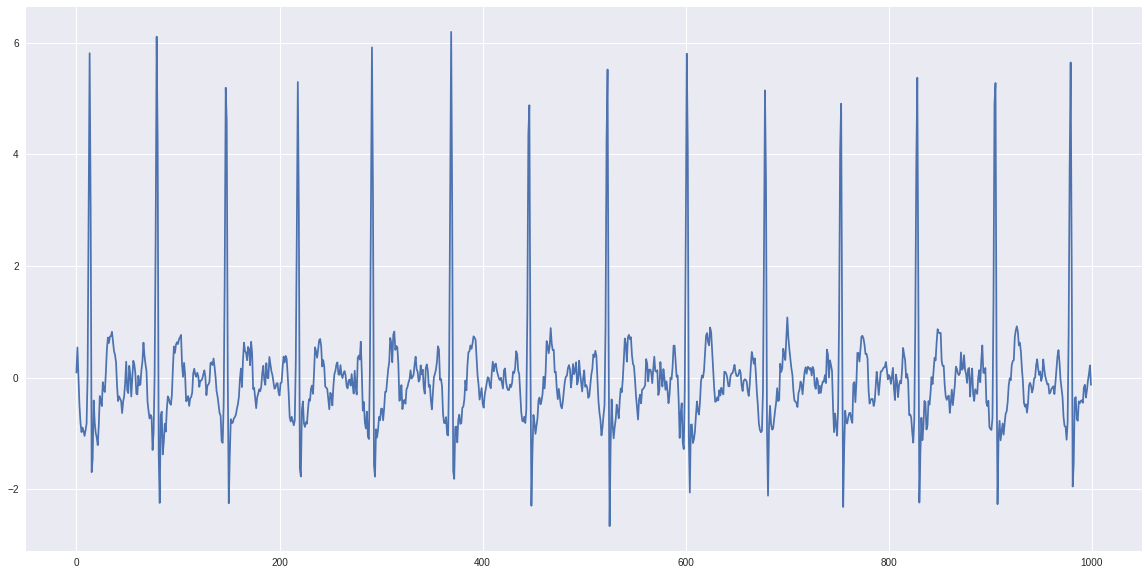

In [0]:
plt.figure(figsize = (20,10))
plt.plot(neu.reshape(1000,)) # plot filtered and normalized Neulog signal

In [0]:
model.predict_proba(neu) #print probability of each class

array([[8.9998943e-01, 8.6332541e-08, 1.0001048e-01]], dtype=float32)